In [3]:
import os
os.chdir('../../../../src')

In [4]:
import matplotlib.pyplot as plt
import torch
from transformer.models import TransformerDecoder
from utils import plot_polygon
from data import PolygonSentenceReader, Polygon

In [14]:
BATCH_SIZE = 1
max_num_context = 10

max_seq_len = 512
min_num_sides = 3
max_num_sides = 8

EOS_TOKEN = -4

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_dim = 1
y_dim = 1

# Reconstruct the Transformer model and load the trained checkpoint
model = TransformerDecoder(x_dim, y_dim, r_dim=128, decoder_layers=2, decoder_heads=8)
checkpoint_path = f"../final_decoder_tf_model_{max_seq_len}_dim_min_{min_num_sides}_max_{max_num_sides}_sides.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to(device)

TransformerDecoder(
  (project_r): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [19]:
polygon_reader = PolygonSentenceReader(
    batch_size=BATCH_SIZE,
    max_num_context=max_num_context,
    max_seq_len=max_seq_len,
    min_num_sides=3,
    max_num_sides=3,
    testing=True,
)

In [30]:
def evaluate_in_context_angles(num_context, plot_samples=False):
    """
    Evaluate the model’s ability to do few-shot in-context angle
    prediction, given full polygons as support and a target polygon
    with its angles withheld.
    """ 
    (
        context_x,  # [B, C, x_size]
        context_y,  # [B, C, y_size]  
        target_x,   # [B, 1, x_size]  
        target_y,   # [B, 1, y_size]
        total_tokens_list,
        true_target_polygons,
        max_seq_len,
        num_context
    ) = polygon_reader.generate_polygon_batch_few_shot_completion_task()

    B, C, x_dim = context_x.shape
    _, _, L_partial = target_x.shape
    _, _, L_angles  = target_y.shape

    total_err = 0.0
    total_count = 0

    with torch.no_grad():
        for i in range(B):
            # Build the initial prompt tokens for sample i
            prompt = []
            for j in range(C):
                toks = context_x[i, j].tolist()
                # strip pads
                while toks and toks[-1] == 0.0:
                    toks.pop()
                prompt += toks
                toks = context_y[i, j].tolist()
                # strip pads
                while toks and toks[-1] == 0.0:
                    toks.pop()
                prompt += toks
                prompt.append(EOS_TOKEN)

            # The partial target (up through SEP_ANGS, excluding angles)
            partial = target_x[i, 0].tolist()
            while partial and partial[-1] == 0.0:
                partial.pop()
            prompt += partial

            prompt_len = len(prompt)

            # Autoregressively generate L_angles tokens ---
            generated = prompt.copy()
            for _ in range(L_angles):
                # if prompt grows beyond max_seq_len, truncate from the left
                if len(generated) > max_seq_len:
                    generated = generated[-max_seq_len:]

                # tensor shape [seq_len, batch=1, 1]
                src = torch.tensor(generated, device=device, dtype=torch.float32)
                src = src.unsqueeze(1).unsqueeze(-1)

                # no padding in generation, so src_key_padding_mask=None
                logits = model(src, src_key_padding_mask=None)  # [L,1,1]
                next_tok = logits[-1, 0, 0].item()              # last position

                generated.append(next_tok)

            # Extract the generated angles and compare to the true angles
            gen_angles = generated[prompt_len : prompt_len + L_angles]
            true_angles = target_y[i, 0, :L_angles].tolist()
            # strip any trailing pads from true_angles
            while true_angles and true_angles[-1] == 0.0:
                true_angles.pop()

            for p, t in zip(gen_angles, true_angles):
                total_err += abs(p - t)
                total_count += 1

    avg_error = total_err / total_count if total_count else float('nan')
    # print(f"→ Avg abs error (autoregressive angles): {avg_error:.4f} degrees")
    # print(f"Predicted angles: {gen_angles}")
    # print(f"True angles: {true_angles}")
    return avg_error

Evaluating for Context Size = 1
  Average absolute error: 54.8199
Evaluating for Context Size = 2
  Average absolute error: 69.0372
Evaluating for Context Size = 3
  Average absolute error: 59.7452
Evaluating for Context Size = 4
  Average absolute error: 59.3380
Evaluating for Context Size = 5
  Average absolute error: 52.4084
Evaluating for Context Size = 6
  Average absolute error: 58.0554
Evaluating for Context Size = 7
  Average absolute error: 58.4953
Evaluating for Context Size = 8
  Average absolute error: 59.8018
Evaluating for Context Size = 9
  Average absolute error: 59.3842


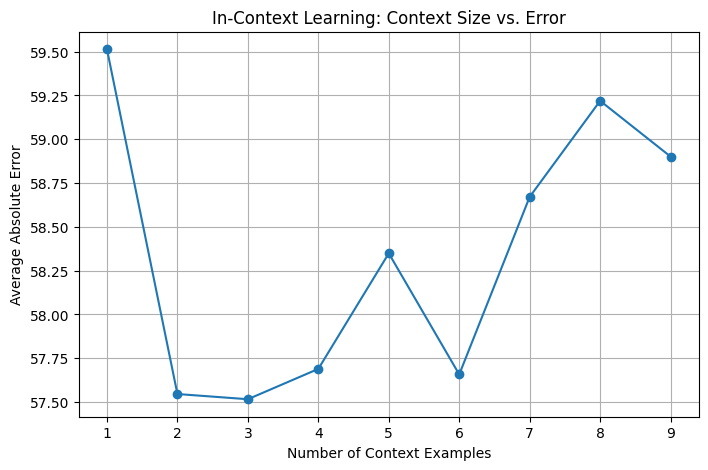

In [33]:
NUM_RUNS = 50
context_sizes = list(range(1, 10))
avg_errors = []
for c in context_sizes:
    print("Evaluating for Context Size =", c)
    print("=" * 50)
    errors = []
    for _ in range(NUM_RUNS):
        error = evaluate_in_context_angles(num_context=c)
        if error is None:
            error = float('nan')
        errors.append(error)
    mean_err = sum(errors) / NUM_RUNS
    avg_errors.append(mean_err)
    print("  Average absolute error: {:.4f}".format(error))

plt.figure(figsize=(8, 5))
plt.plot(context_sizes, avg_errors, marker='o')
plt.xlabel("Number of Context Examples")
plt.ylabel("Average Absolute Error")
plt.title("In-Context Learning: Context Size vs. Error")
plt.grid(True)
plt.show()